CNN -> 데이터 전처리->CNN으로 이미지 분류 ->전이학습모델 VGG 분류

In [1]:
import matplotlib.pyplot as plt
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor

In [2]:
training_data =  CIFAR10(
    root='./', train=True,download=True,transform=ToTensor()
)
test_data =  CIFAR10(
    root='./', train=False,download=True,transform=ToTensor()
)

100%|██████████| 170498071/170498071 [00:01<00:00, 104721243.41it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


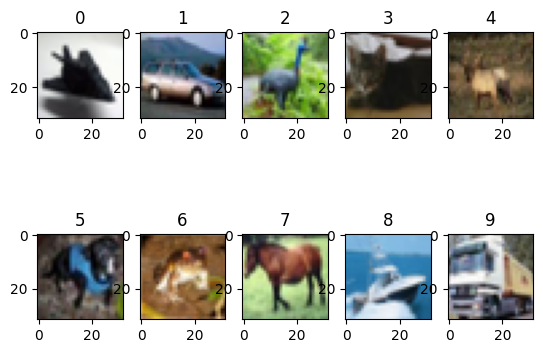

In [37]:
import numpy as np
class_indexs = [np.where(np.array(training_data.targets) == i)[0][0]   for i in range(10)]
for i, idx in enumerate(class_indexs):
  plt.subplot(2,5,i+1)
  plt.imshow(training_data.data[idx])
  plt.title(i)
plt.show()

In [ ]:
# 데이터 개수 확인
training_data.data.shape

데이터증강
  - 데이터가 부족하거나 오퍼피팅(과적합)을 피하는 기법

In [3]:
# 데이터 증강
import torchvision.transforms as T
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop

100%|██████████| 170498071/170498071 [00:01<00:00, 96455871.02it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


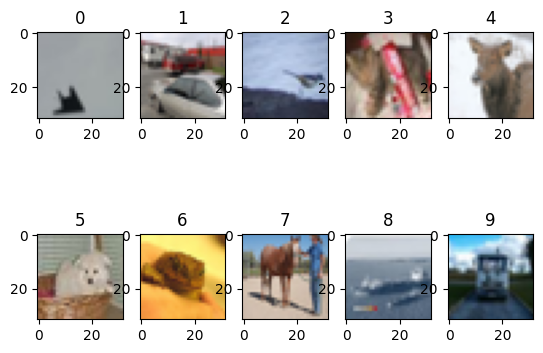

In [4]:
transforms = Compose([
    # ToTensor(),
    T.ToPILImage(),
    RandomCrop((32,32),padding=4), # 랜덤으로 이미지 일부 제거하고 패딩
    RandomHorizontalFlip(p=0.5)  # 좌우대칭
])


training_data =  CIFAR10(
    root='./', train=True,download=True,transform=transforms
)
test_data =  CIFAR10(
    root='./', train=False,download=True,transform=transforms
)

import numpy as np
class_indexs = [np.where(np.array(training_data.targets) == i)[0][-1]   for i in range(10)]
for i, idx in enumerate(class_indexs):
  plt.subplot(2,5,i+1)
  plt.imshow(training_data.data[idx])
  plt.title(i)
plt.show()

In [5]:
training_data.data.shape

(50000, 32, 32, 3)

이미지 정규화
  - RGB
  - 빨간색 자동차는 빨간색이 많다. 즉 치우쳐져 있다

In [7]:
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop,Normalize

In [ ]:
transforms = Compose([
    RandomCrop((32,32),padding=4), # 랜덤으로 이미지 일부 제거하고 패딩
    RandomHorizontalFlip(p=0.5),  # 좌우대칭
    ToTensor(),
    Normalize(mean=(0.49139968, 0.48215827, 0.44653124), std=(0.24703233, 0.24348505, 0.26158768)),  # 데이터 정규화

])

training_data =  CIFAR10(
    root='./', train=True,download=True,transform=transforms
)
test_data =  CIFAR10(
    root='./', train=False,download=True,transform=transforms
)

import numpy as np
class_indexs = [np.where(np.array(training_data.targets) == i)[0][0]   for i in range(10)]
for i, idx in enumerate(class_indexs):
  plt.subplot(2,5,i+1)
  plt.imshow(training_data.data[idx])
  plt.title(i)
plt.show()

In [17]:
training_data.data.shape

(50000, 32, 32, 3)

데이터 정규화 수치 얻는 방법

In [33]:
import torch
training_data =  CIFAR10(
    root='./', train=True,download=True,transform=ToTensor()
)
imgs = [item[0] for item in training_data]   # item[0] 데이터, item[1] 라벨

Files already downloaded and verified


In [34]:
# stack : 텐서를 dim 방향으로 합쳐
# (224,224) 텐서를 dim=0방향으로 3개를 합치면
# (3,224,224)
imgs = torch.stack(imgs,dim=0).numpy()
print(imgs.shape)

(50000, 3, 32, 32)


In [39]:
# 각 rgb의 평균
r_mean = imgs[:,0,:,:].mean()
g_mean = imgs[:,1,:,:].mean()
b_mean = imgs[:,2,:,:].mean()
print(r_mean, g_mean, b_mean)

# 각 rgb 표준편차
r_std = imgs[:,0,:,:].std()
g_std = imgs[:,1,:,:].std()
b_std = imgs[:,2,:,:].std()
print(r_std, g_std, b_std)

0.49139968 0.48215827 0.44653124
0.24703233 0.24348505 0.26158768


CNN으로 이미지 분류

In [43]:
from weakref import KeyedRef
# C-R-C-R-MP  : 기본 CNN 블럭
import torch.nn as nn
class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, hidden_dim):
    super(BasicBlock,self).__init__()
    # 합성곱층 정의
    self.conv1 = nn.Conv2d(
        in_channels, hidden_dim, kernel_size=3,padding=1
    )
    self.conv2 = nn.Conv2d(
        hidden_dim, out_channels, kernel_size=3,padding=1
    )
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
  # 연결--> 전방계산 forward
  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    output = self.pool(x)
    return output

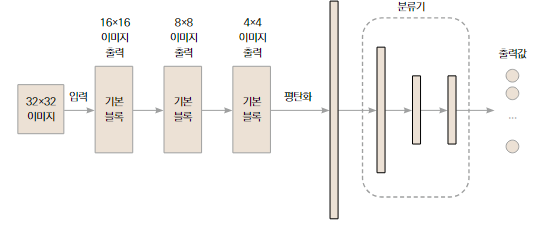

VGG 모델 정의

In [45]:
class CNN(nn.Module):
  def __init__(self, num_class): # num_class 클래스 개수
    super(CNN,self).__init__()
    # 합성곱의 기본 블럭 정의
    self.block1 = BasicBlock(in_channels=3, out_channels=32, hidden_dim=16)
    self.block2 = BasicBlock(in_channels=32, out_channels=128, hidden_dim=64)
    self.block3 = BasicBlock(in_channels=128, out_channels=256, hidden_dim=128)

    # 분류기
    self.fc1 = nn.Linear(in_features=256, out_features=2048)
    self.fc2 = nn.Linear(in_features=2048, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=num_class)
    self.relu = nn.ReLU()
  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = torch.flatten(x, start_dim=1) # dim 0은 데이터의 개수 즉 배치크기

    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    output = self.fc3(x)

    return output

In [46]:
model = CNN(10)